Configure the data base, taken from https://www.sports-reference.com/cfb/years/2024-passing.html 

In [197]:
import pandas as pd 
import numpy as np

# load the data 
qb_data = pd.read_csv("QBCollegeStats.csv")

# data is stored in one column, separate it into separate columns
if qb_data.shape[1] == 1:
    qb_data = qb_data[qb_data.columns[0]].str.split(",", expand=True)

# Set column headers 
qb_data.columns = ["Rk", "Player", "Team", "Conf", "G", "Cmp", "Att", "Cmp%", "Yds",
 "TD", "TD%", "Int", "Int%", "Y/A", "AY/A", "Y/C", "Y/G", "Rate",
 "Awards", "Player-additional"]

#rename conferences of these two teams as they are stored wrong in database
qb_data.loc[qb_data["Team"].isin(["Oregon State", "Washington State"]), "Conf"] = "Pac-12"

Box plot of QB rating by Conference

<Figure size 1000x600 with 0 Axes>

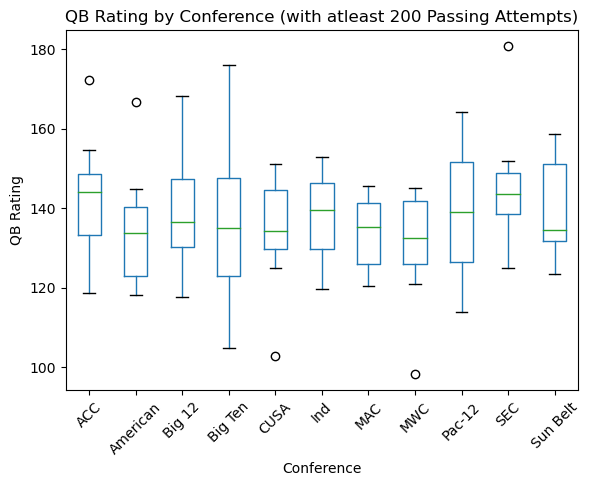

In [198]:
import matplotlib.pyplot as plt

#ensure QB rating and QB passing attempts is numeric values
qb_data["Rate"] = pd.to_numeric(qb_data["Rate"])
qb_data["Att"] = pd.to_numeric(qb_data["Att"])

# Filter for QBs with atleast 200 passing attempts
qb_data_filtered = qb_data[(qb_data["Att"] >= 200)]

# Plot figure
plt.figure(figsize=(10, 6))

# plot boxplot with data grouped conference
qb_data_filtered.boxplot(column="Rate", by="Conf", grid = False)

#plot axis
plt.title("QB Rating by Conference (with atleast 200 Passing Attempts)")
plt.suptitle("")
plt.xlabel("Conference")
plt.ylabel("QB Rating")

#rotate labels of x axis to make it more legible 
plt.xticks(rotation=45)

#store it as pdf in a folder
FIG = "./outputs/"
plt.savefig(FIG+"QBRatingBoxPlot.pdf")

plt.show()

Import advance modeling tools

In [199]:
from econml.dml import CausalForestDML
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant

#name the power 5 conferences 
power5_conferences = ["SEC", "Big Ten", "Big 12", "ACC", "Pac-12"]

# make a copy to avoid SettingWithCopyWarning
qb_data_filtered = qb_data_filtered.copy()

# Create a binary Power5 column, uses loc to avoid SettingWithCopyWarning
qb_data_filtered.loc[:, "Power5"] = qb_data_filtered["Conf"].apply(lambda x: 1 if x in power5_conferences else 0)

# Select numeric columns for the model, input variable
X = qb_data_filtered[[
    "Rk", "G", "Cmp", "Att", "Cmp%", "Yds", "TD", "TD%", "Int", "Int%",
    "Y/A", "AY/A", "Y/C", "Y/G"
]]

#dependent variable
D = qb_data_filtered["Power5"]

#output variable
Y = qb_data_filtered["Rate"]

Linear Regression Model

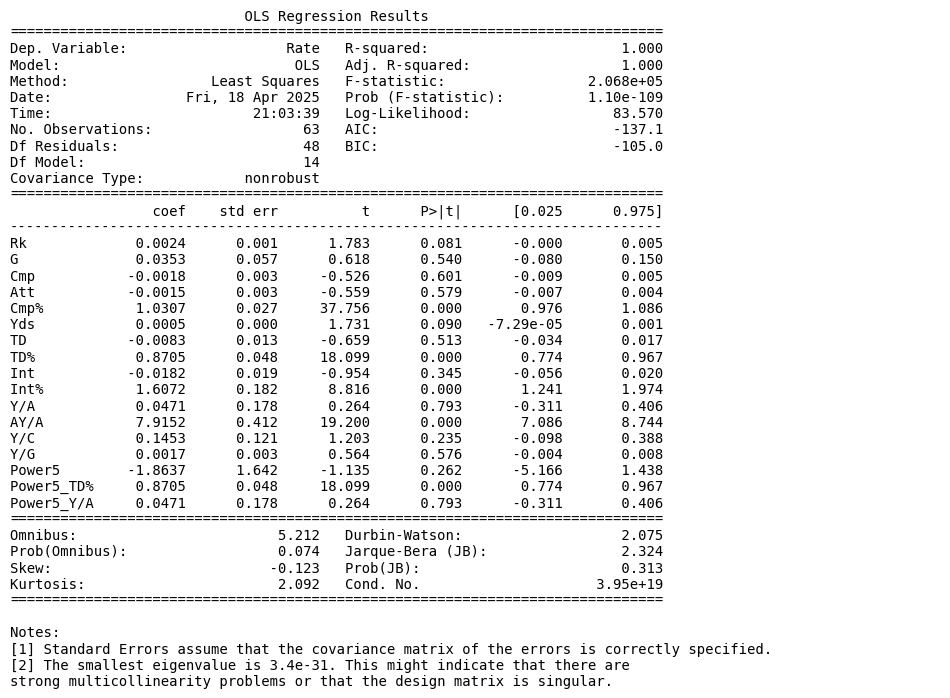

In [200]:
# Combine input variable and dependent variable into one data frame
combined = pd.concat([Y, X_with_D], axis=1)

# Drop rows that contain values such as "NaNs"
combined_clean = combined.dropna()
Y_clean = combined_clean["Rate"]
X_clean = combined_clean.drop(columns=["Rate"])

# Data stored were still objects, convert it all to numerical
X_clean = X_clean.apply(pd.to_numeric)
Y_clean = pd.to_numeric(Y_clean)

# merge again and drop rows that converted into "NaNs" value after conversioj
combined_final = pd.concat([Y_clean, X_clean], axis=1).dropna()

# Split it back to X and Y
Y_clean = combined_final.iloc[:, 0]
X_clean = combined_final.iloc[:, 1:]

#add a constant term for X 
X_clean = add_constant(X_clean)

#create a OLS regression model
OLS_regression_model = OLS(Y_clean, X_clean).fit()

# Create a figure (to store it as a pdf)
fig, ax = plt.subplots(figsize=(12, 8))
#remove axis 
ax.axis("off") 

# Convert the summary to a string
OLS_summary = OLS_regression_model.summary().as_text()

# Plot the text which was converted as a string onto the figure
ax.text(0, 1, OLS_summary, fontsize=10, va="top", family="monospace")

# Store as PDF 
plt.savefig(FIG + "OLS_Regression_Summary.pdf", bbox_inches="tight")

#output
plt.show()

Estimate casual forest

In [201]:
cf = CausalForestDML(
    model_y=GradientBoostingRegressor(),
    model_t=GradientBoostingClassifier(), #use a classifier for treatement
    discrete_treatment=True,
    random_state=42
)

#fitting the treatment effects into the model
cf.fit(Y, D, X=X)
tau_hat = cf.effect(X)
tau_hat_se = cf.effect_interval(X)

#check and print summary
cf.summary()

Population summary results are available only if `cache_values=True` at fit time!


,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
ATE,-6.894,8.063,-0.855,0.393,-22.697,8.91
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
ATT,-4.985,14.408,-0.346,0.729,-33.225,23.255
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
ATT,-8.65,7.985,-1.083,0.279,-24.3,6.999


Histogram of treatment effects

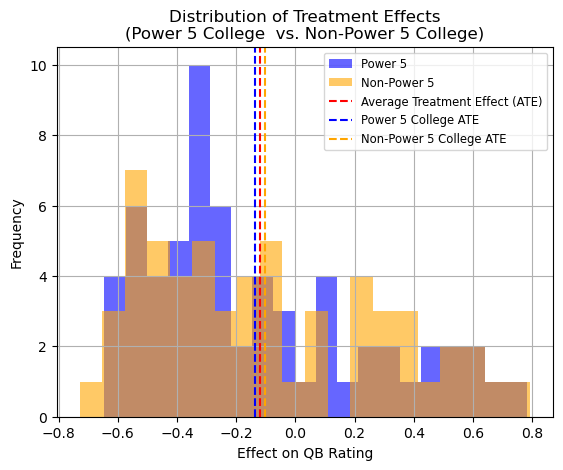

ATE (All): -0.11977030227009901
ATE (Power 5): -0.13608495745560845
ATE (Non-Power 5): -0.10204921129273525


In [202]:
# Separate based on actual Power 5 status
tau_power5 = tau_hat[D == 1]
tau_nonpower5 = tau_hat[D == 0]

#plot histogram
plt.hist(tau_power5, bins=20, alpha=0.6, label="Power 5", color="blue")
plt.hist(tau_nonpower5, bins=20, alpha=0.6, label="Non-Power 5", color="orange")
#plot average treatement effect line
plt.axvline(np.mean(tau_hat), color="red", linestyle="--", label= "Average Treatment Effect (ATE)")
plt.axvline(np.mean(tau_power5), color="blue", linestyle="--", label= "Power 5 College ATE")
plt.axvline(np.mean(tau_nonpower5), color="orange", linestyle="--", label= "Non-Power 5 College ATE")

#plot axis, legend and grid 
plt.title("Distribution of Treatment Effects\n(Power 5 College  vs. Non-Power 5 College)")
plt.xlabel("Effect on QB Rating")
plt.ylabel("Frequency")
plt.legend(fontsize = "small")
plt.grid(True)

#store it as pdf in a folder
plt.savefig(FIG+"QBRatingATE.pdf")

#output diagram
plt.show()

#print the values of ATE 
print("ATE (All):", np.mean(tau_hat))
print("ATE (Power 5):", np.mean(tau_power5))
print("ATE (Non-Power 5):", np.mean(tau_nonpower5))

Ordered treatment effects

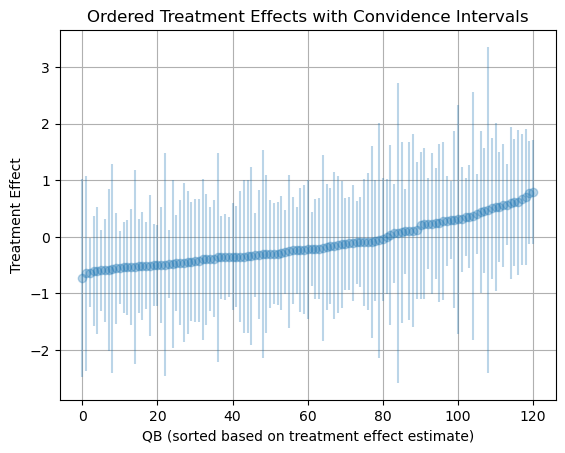

In [203]:
#flatten treatment effect to estimate effects of a 1D array
effects = tau_hat.flatten()

#calculate confidence intervals 
ci = tau_hat_se[1] - effects

#sort treatment effects for a clearer visualisation 
sorted_index= np.argsort(effects)

#plot treatment effects with error bars which are confidence intervals, 
#each point is a QB and sorted by their estimated treatement effect
plt.errorbar(
    np.arange(len(effects)), 
    effects[sorted_index], 
    yerr=ci[sorted_index], 
    fmt='o', 
    alpha=0.3)

#plot axis 
plt.title("Ordered Treatment Effects with Convidence Intervals")
plt.xlabel("QB (sorted based on treatment effect estimate)")
plt.ylabel("Treatment Effect")
plt.grid(True)

#store as pdf
plt.savefig(FIG+"CIOTE.pdf") 

#output diagram
plt.show()

Subgroup Treatment effect

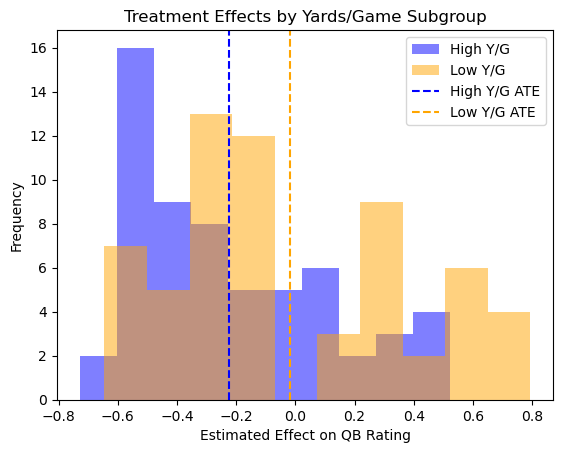

In [204]:
#make a copy to avoid SettingWithCopyWarning
qb_data_filtered = qb_data_filtered.copy()

#Convert "Y/G" Column to numerical as it is stored as a string
qb_data_filtered["Y/G"] = pd.to_numeric(qb_data_filtered["Y/G"])

#split data into high yards per game and low yards per game using the median
high_yards_per_game = qb_data_filtered["Y/G"] > qb_data_filtered["Y/G"].median()
low_yards_per_game = ~high_yards_per_game

#get treatment effects of both groups
tau_high = cf.effect(X[high_yards_per_game])
tau_low = cf.effect(X[low_yards_per_game])

#plot treatment effect for each group using histogram
plt.hist(tau_high, alpha=0.5, color="blue", label="High Y/G")
plt.hist(tau_low, alpha=0.5, color="orange", label="Low Y/G")

# Plot ATE lines for each group
plt.axvline(np.mean(tau_high), color="blue", linestyle="--", label="High Y/G ATE")
plt.axvline(np.mean(tau_low), color="orange", linestyle="--", label="Low Y/G ATE")

#plot labels 
plt.legend()
plt.title("Treatment Effects by Yards/Game Subgroup")
plt.xlabel("Estimated Effect on QB Rating")
plt.ylabel("Frequency")

#store as pdf
plt.savefig(FIG+"TreatmentEffectsSubgroup.pdf") 

#output diagram
plt.show()

SHAP Summary

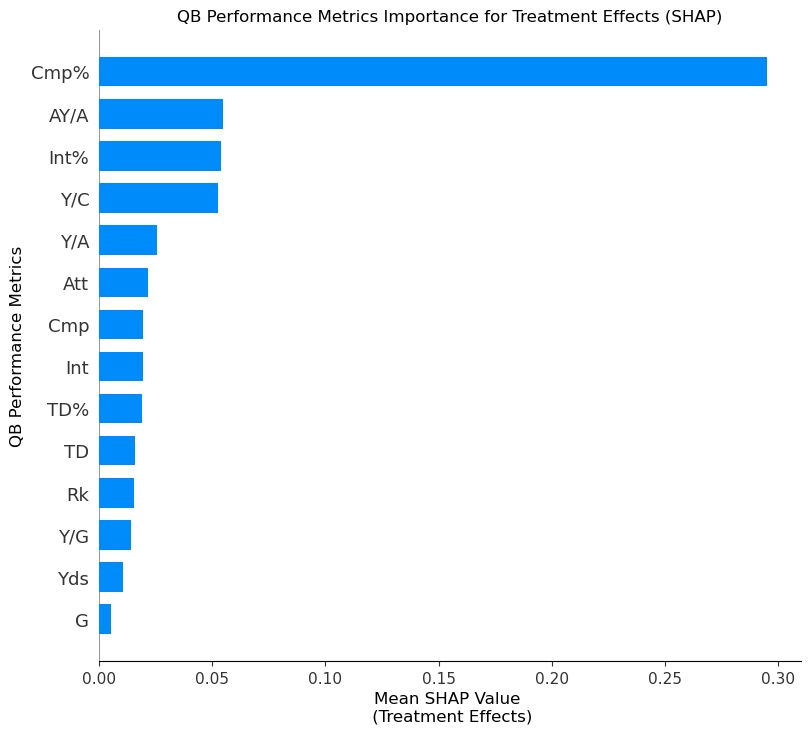

In [205]:
import shap

# Ensure X is all numeric
X = X.apply(pd.to_numeric, errors="coerce").dropna()


# Plot SHAP summary bar chart
shap.summary_plot(
    shap_values.values,
    features=X,
    feature_names=X.columns,
    plot_type="bar",
    show=False)

#plot axis
plt.title("QB Performance Metrics Importance for Treatment Effects (SHAP)")
plt.xlabel("Mean SHAP Value \n (Treatment Effects)", fontsize=12)
plt.ylabel("QB Performance Metrics", fontsize = 12)


#store as pdf
plt.savefig(FIG+"SHAPvalues.pdf")

#out
plt.show()


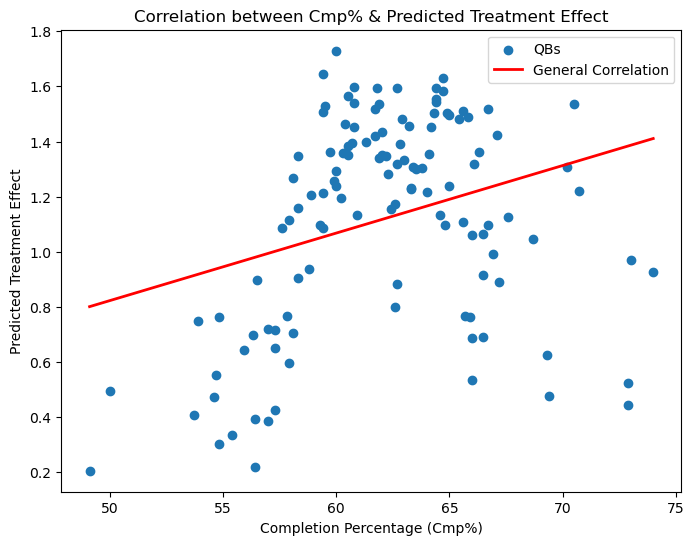

In [210]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

# Convert "Cmp%" values to numeric as they are stored as strings
cmp_percent = pd.to_numeric(qb_data_filtered.loc[X.index, "Cmp%"], errors='coerce').values

# Get predicted treatment effects
te_predicts = cf.const_marginal_effect(X).flatten()

# Remove any missing values so we can plot properly
valid_data = ~np.isnan(cmp_percent) & ~np.isnan(te_predicts)
cmp_percent = cmp_percent[valid_data]

#reverse the data as retrieved treatment effect is reversed 
te_predicts = 1 - te_predicts[valid_data]

# generate a simple linear regression model to show relation between "cmp%" and predicted treatment effect
model = LinearRegression()
cmp_reshaped = cmp_percent.reshape(-1, 1)
model.fit(cmp_reshaped, te_predicts)
line_x = np.linspace(cmp_percent.min(), cmp_percent.max(), 100).reshape(-1, 1)
line_y = model.predict(line_x)

# Plot the scatter graph and the trend line
plt.figure(figsize=(8, 6))
plt.scatter(cmp_percent, te_predicts, label="QBs")
plt.plot(line_x, line_y, color="red", linewidth=2, label="General Correlation")

# plot axis, title and legend
plt.xlabel("Completion Percentage (Cmp%)")
plt.ylabel("Predicted Treatment Effect")
plt.title("Correlation between Cmp% & Predicted Treatment Effect")
plt.legend()

# store as pdf 
plt.savefig(FIG + "Cmp_vs_TreatmentEffect_MPL.pdf")

#output
plt.show()